In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# add your path

df = pd.read_pickle("/Users/marianamatos/ppgti/data-centric-ia/weak-supervised-fraud-detection/data/df_treated.pkl")
df.shape

(23634, 16)

Fraud rate for entire dataframe:

In [30]:
print(df['is_fraudulent'].sum()/df.shape[0] * 100)

5.17051705170517


### Objective

This step focus on analysing the behaviour every feature has on the target. Hopping to identify some patterns.

### Methodology:
Analyze high cardinality variables, numerical variables, categorical variables, and fraud analysis over time separately, but we will not explore deeply into time series.

**High cardinality variables**: We will perform feature engineering to create new variables with categories that highlight characteristics observed in the univariate analysis.

**Categorical variables**: Contingency Table, fraud rate, data viz.  

**Numerical variables**: data viz, descriptive analysis over target.  

**Time series**: check if it could indicate something.  


We (myself and the voices in my head) created seven new variables to explore the relationship between high cardinality variables, hoping to uncover some relevant information.


* is_repeated_ip
* shipping_address_repeated
* billing_address_repeated
* is_addrss_ship_bill
* common_customer_location
* address_ip_relationship
* ip_and_address_combo


In [31]:
high_cardinality = ['customer_location','ip_address', "shipping_address", 'billing_address']

1.less common neighborhoods might pose a potential risk?  
1. common address  
2. not common  

2.other variable: does the ip from different addresses are the same?  
1. different_ip same address  
2. different address same ip  
3. data are the same  
4. different ip, different addrss
  
3.one variabel check for two datas: (ip+ billing + shiping)  
1. is duble ip   
2. is double addrss  
3. is double ip and addrss  
4. not double  


In [32]:
# 1. Categorizes customer_location as "common" or "not common"
location_counts = df['customer_location'].value_counts()
common_locations = location_counts[location_counts >= 10].index
df['common_customer_location'] = np.where(
    df['customer_location'].isin(common_locations), 'common', 'not common')

# 2. Categorizes relation between ip_address, billing_address and shipping_address
df['address_ip_relationship'] = 'data_are_the_same'
df.loc[(df['ip_address'].shift() != df['ip_address'])
        & (df['billing_address'] == df['shipping_address']),
        'address_ip_relationship',
        ] = 'different_ip_same_address'

df.loc[(df['ip_address'].shift() == df['ip_address'])
        & (df['billing_address'] != df['shipping_address']),
        'address_ip_relationship',
        ] = 'different_address_same_ip'

df.loc[(df['ip_address'].shift() != df['ip_address'])
        & (df['billing_address'] != df['shipping_address']),
        'address_ip_relationship',
        ] = 'different_ip_different_address'

# 3. Categorize observations between duplicated addresses and ip
# Combine billing and shipping address into a single string for comparison
df['combined_address_aux'] = df['billing_address'] + '_' + df['shipping_address']

ip_counts = df['ip_address'].value_counts()
address_counts = df['combined_address_aux'].value_counts()

# Create the new categorical column based on duplication
df['is_ip_address_double'] = 'not_double' 

df.loc[df['ip_address'].isin(ip_counts[ip_counts > 1].index), 'is_ip_address_double'] = 'double_ip'
df.loc[df['combined_address_aux'].isin(address_counts[address_counts > 1].index), 'is_ip_address_double'] = 'double_address'
df.loc[ df['ip_address'].isin(ip_counts[ip_counts > 1].index)
         & df['combined_address_aux'].isin(address_counts[address_counts > 1].index),
        'is_ip_address_double',
        ] = 'double_ip_and_address'

# Clean up the temporary col
df.drop(columns=['combined_address_aux'], inplace=True)

In [33]:
df['is_ip_address_double'].value_counts()

is_ip_address_double
not_double    23634
Name: count, dtype: int64

Simple categorization, only for the column data

In [34]:
# Address data appears more than once
shipping_address_counts = df['shipping_address'].value_counts()
df['shipping_address_repeated'] = df['shipping_address'].isin(shipping_address_counts[shipping_address_counts > 1].index)

billing_address_counts = df['billing_address'].value_counts()
df['billing_address_repeated'] = df['billing_address'].isin(billing_address_counts[billing_address_counts > 1].index)

# Are addresses the same?
df['is_addrss_ship_bill'] = (df['shipping_address'] == df['billing_address'])

##### Categorical variables insights

<ins> payment_method vs. is_fraudulent: </ins>
All payment categories have similar fraud risk when we analyze the exposure of the fraud rate variable.

<ins>product_category vs. is_fraudulent: </ins>
Product categories also have similar risk

<ins>device_used vs. is_fraudulent: </ins>
Could not gave us insights about its fraud behavior 

<ins>is_addrss_ship_bill vs. is_fraudulent:</ins>
We see here that the distributions are different, as expected, but the fraud rate in the categories are almost the same (5%)

<ins>common_customer_location vs. is_fraudulent:</ins>
Same as we observed above in the ‘is_addrss_ship_bill‘

<ins>address_ip_relationship vs. is_fraudulent:</ins>
Same as we observed above in the ‘is_addrss_ship_bill‘

<ins>is_ip_address_double vs. is_fraudulent:</ins>
Categorie double address only show 4 records and they are all non-fraudulent. Although, double_ip and not_double have similar fraud rate (5%)


In [21]:
# 1. Categorical Variables vs. is_fraudulent
def analyze_categorical_vs_fraud(df, categorical_column):
    print(f"\n--- Bivariate Analysis: {categorical_column} vs. is_fraudulent ---")

    if categorical_column not in df.columns:
        print(f"Error: The column '{categorical_column}' does not exist in the DataFrame.")
        return None
    
    # Contingency table
    contingency_table = pd.crosstab(df[categorical_column], df['is_fraudulent'])
    print("\nContingency Table:\n", contingency_table)

    # Calculate fraud rates per category
    total_per_category = df.groupby(categorical_column)["is_fraudulent"].count()
    df_fraud_rate = df[df['is_fraudulent'] == 1].groupby(categorical_column)['is_fraudulent'].count()

    rate_per_category = (df_fraud_rate / total_per_category).fillna(0).sort_values(ascending=False)
    print("\nFraud Rates per Category:\n", rate_per_category)

    # Stacked bar chart
    contingency_table.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title(f'Fraud Distribution by {categorical_column}')
    plt.xlabel(categorical_column)
    plt.ylabel('Transaction Count')
    plt.show()


--- Bivariate Analysis: payment_method vs. is_fraudulent ---

Contingency Table:
 is_fraudulent      0    1
payment_method           
PayPal          5589  310
bank transfer   5534  326
credit card     5622  301
debit card      5667  285

Fraud Rates per Category:
 payment_method
bank transfer    0.055631
PayPal           0.052551
credit card      0.050819
debit card       0.047883
Name: is_fraudulent, dtype: float64


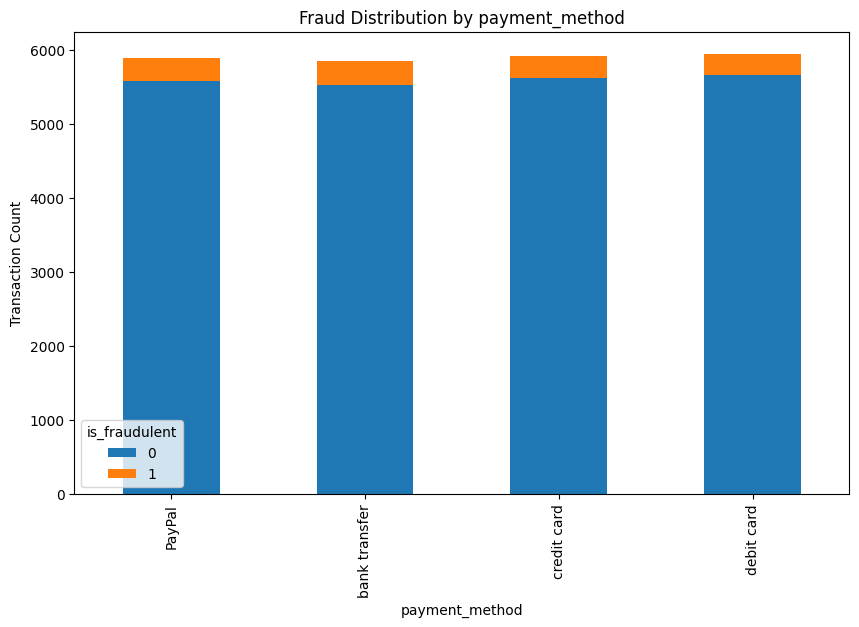


--- Bivariate Analysis: product_category vs. is_fraudulent ---

Contingency Table:
 is_fraudulent        0    1
product_category           
clothing          4439  260
electronics       4519  229
health & beauty   4427  244
home & garden     4528  258
toys & games      4499  231

Fraud Rates per Category:
 product_category
clothing           0.055331
home & garden      0.053907
health & beauty    0.052237
toys & games       0.048837
electronics        0.048231
Name: is_fraudulent, dtype: float64


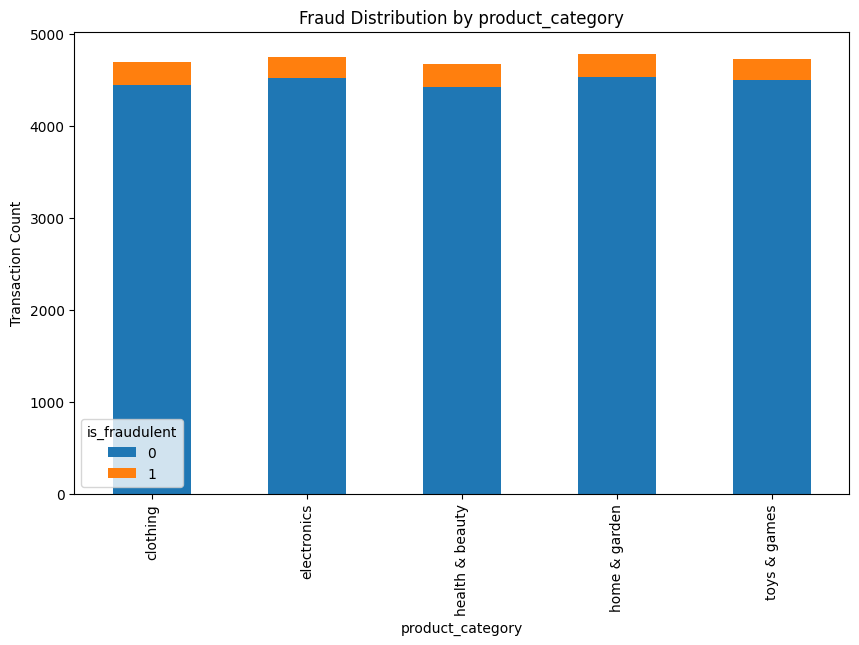


--- Bivariate Analysis: device_used vs. is_fraudulent ---

Contingency Table:
 is_fraudulent     0    1
device_used             
desktop        7517  406
mobile         7452  429
tablet         7443  387

Fraud Rates per Category:
 device_used
mobile     0.054435
desktop    0.051243
tablet     0.049425
Name: is_fraudulent, dtype: float64


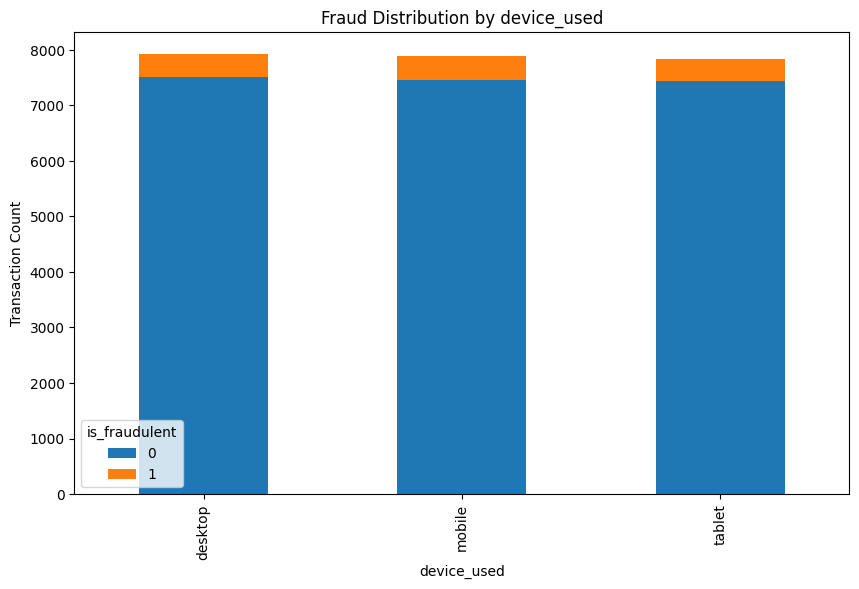


--- Bivariate Analysis: is_addrss_ship_bill vs. is_fraudulent ---

Contingency Table:
 is_fraudulent            0     1
is_addrss_ship_bill             
False                 2217   125
True                 20195  1097

Fraud Rates per Category:
 is_addrss_ship_bill
False    0.053373
True     0.051522
Name: is_fraudulent, dtype: float64


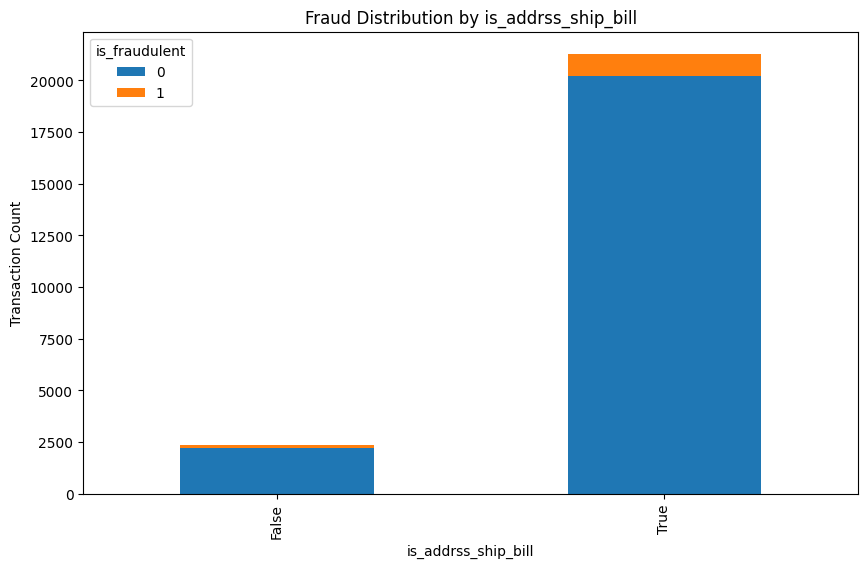


--- Bivariate Analysis: common_customer_location vs. is_fraudulent ---

Contingency Table:
 is_fraudulent                 0     1
common_customer_location             
common                     1236    56
not common                21176  1166

Fraud Rates per Category:
 common_customer_location
not common    0.052189
common        0.043344
Name: is_fraudulent, dtype: float64


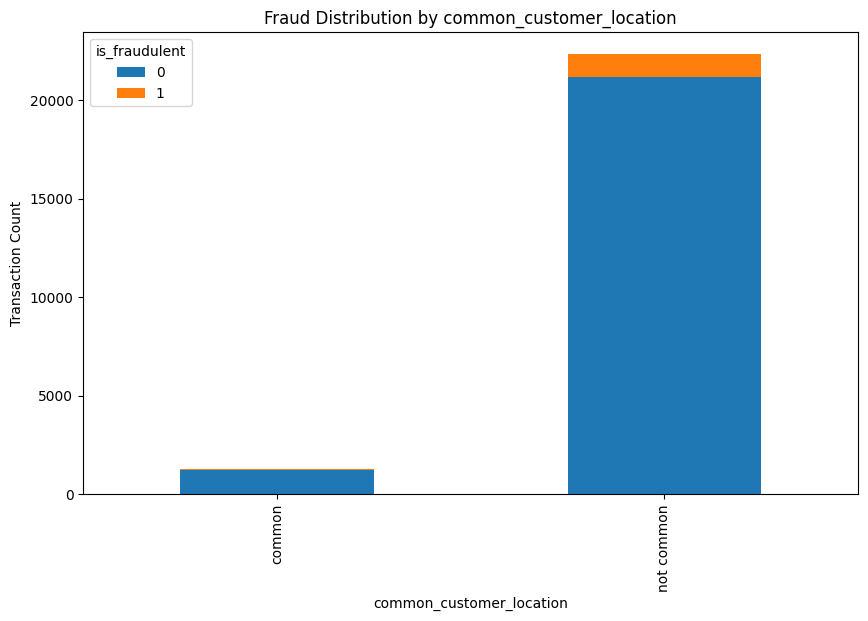


--- Bivariate Analysis: address_ip_relationship vs. is_fraudulent ---

Contingency Table:
 is_fraudulent                       0     1
address_ip_relationship                    
different_ip_different_address   2217   125
different_ip_same_address       20195  1097

Fraud Rates per Category:
 address_ip_relationship
different_ip_different_address    0.053373
different_ip_same_address         0.051522
Name: is_fraudulent, dtype: float64


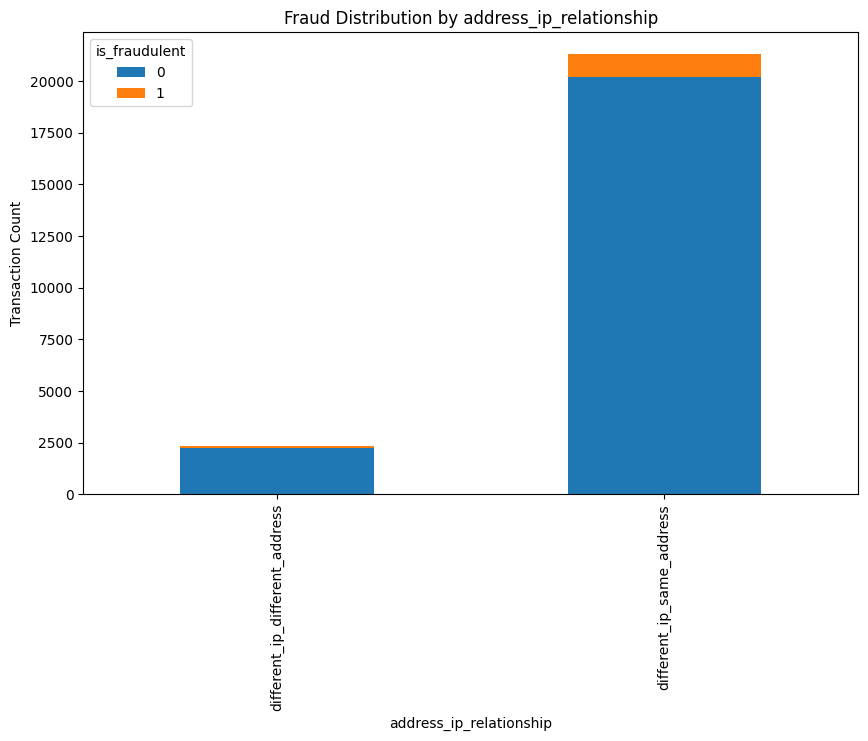


--- Bivariate Analysis: is_ip_address_double vs. is_fraudulent ---

Contingency Table:
 is_fraudulent             0     1
is_ip_address_double             
not_double            22412  1222

Fraud Rates per Category:
 is_ip_address_double
not_double    0.051705
Name: is_fraudulent, dtype: float64


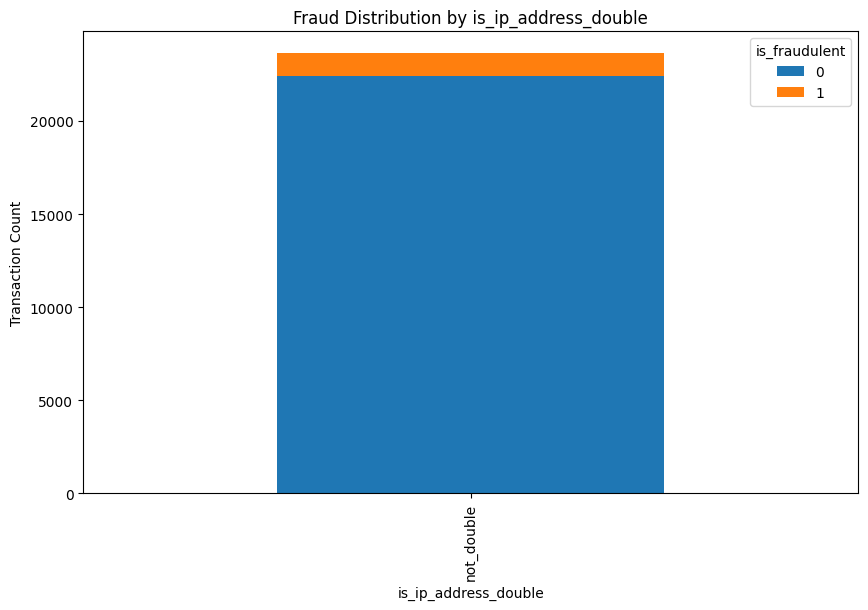


--- Bivariate Analysis: location_appears_more_than_once vs. is_fraudulent ---
Error: The column 'location_appears_more_than_once' does not exist in the DataFrame.


In [22]:
categorical_variables = ['payment_method', 'product_category', 'device_used', 'is_addrss_ship_bill','common_customer_location','address_ip_relationship','is_ip_address_double','location_appears_more_than_once']

for var in categorical_variables:
    analyze_categorical_vs_fraud(df, var)

##### Numerical variable insights

<ins>transaction_amount vs. is_fraudulent:</ins> Fraudulent transactions show a much wider spread, with a considerably higher maximum value (12701.75) compared to non-fraudulent transactions (3570.78), while Non-fraudulent transactions have a tighter distribution around the mean and median. **Higher transaction amounts might be an indicator of potentially fraudulent activity**. While there are non-fraudulent transactions with large amounts, the central tendency and the upper range of transaction amounts are notably higher for fraudulent transactions in this dataset.
 
<ins>quantity vs. is_fraudulent:</ins> Does not give us any insights about fraudulent behavior.

<ins> customer_age vs. is_fraudulent:</ins> does not give us any insights about fraudulent behavior. We are still seeing ages under 0, must correct in the next step (notebook)

<ins>account_age_days vs. is_fraudulent:</ins>This is expected to be a common behavior observed in fraud, and it's what was observed in this descriptive analysis. The 25th and 50th percentiles are much lower for fraudulent transactions, highlighting the **tendency for fraud to occur with younger accounts**. The mean and median account ages for fraudulent transactions are noticeably lower than those for non-fraudulent transactions. This suggests that newer accounts might be more susceptible to fraudulent activity in this dataset

<ins>transaction_hour vs. is_fraudulent</ins>: The mean and median transaction hours for fraudulent transactions are noticeably lower than those for non-fraudulent transactions. This suggests a **tendency for fraudulent activities to be more concentrated in the earlier hours of the day**. The standard deviations for both groups are quite similar, although the central tendency differs. Hints that fraudulent transactions might be more likely to occur during the earlier hours of the day compared to legitimate transactions







In [23]:
# 2. Numerical Variables vs. is_fraudulent
def analyze_numerical_vs_fraud(df, numerical_column):
    print(f"\n-----------------------------------------------------------------------")
    print(f"--- Bivariate Analysis: {numerical_column} vs. is_fraudulent ---")
    print(f"-----------------------------------------------------------------------")


    # Box plots
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='is_fraudulent', y=numerical_column, data=df)
    plt.title(f'Box Plot of {numerical_column} by Fraud')
    plt.xlabel('Fraud (0: No, 1: Yes)')
    plt.ylabel(numerical_column)
    plt.show()

    # Density plots
    plt.figure(figsize=(8, 6))
    sns.kdeplot(df.loc[df['is_fraudulent'] == 0, numerical_column], label='No Fraud', fill=True)
    sns.kdeplot(df.loc[df['is_fraudulent'] == 1, numerical_column], label='Fraud', fill=True)
    plt.title(f'Density Plot of {numerical_column} by Fraud')
    plt.xlabel(numerical_column)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    # Descriptive statistics
    descriptive_statistics = df.groupby('is_fraudulent')[numerical_column].describe()
    print("\nDescriptive Statistics:\n", descriptive_statistics)



-----------------------------------------------------------------------
--- Bivariate Analysis: transaction_amount vs. is_fraudulent ---
-----------------------------------------------------------------------


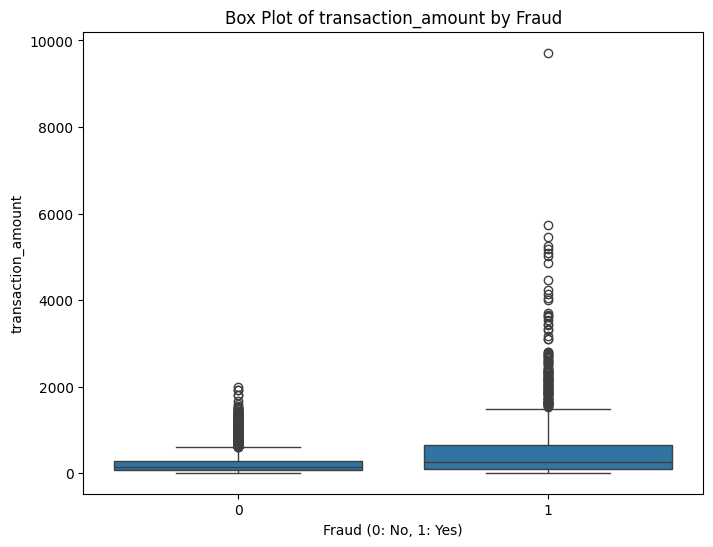

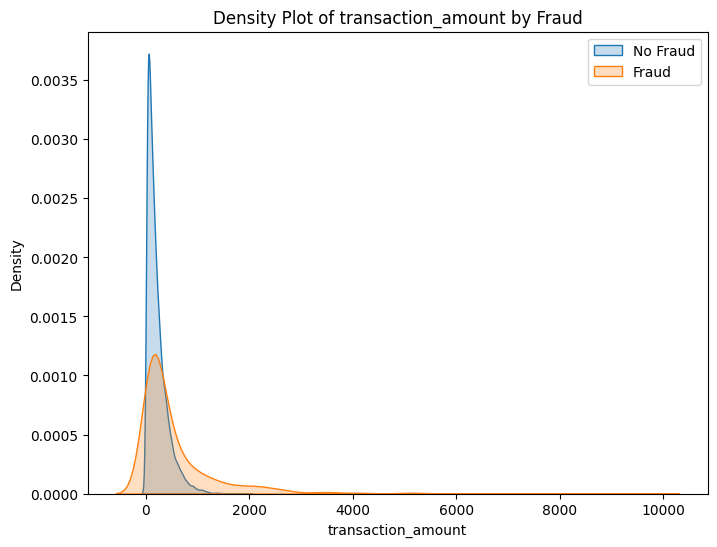


Descriptive Statistics:
                  count        mean         std    min      25%      50%  \
is_fraudulent                                                             
0              22412.0  211.226000  202.803353  10.00   67.885  148.205   
1               1222.0  562.082561  817.306472  10.06  100.500  251.025   

                    75%      max  
is_fraudulent                     
0              287.0175  1980.94  
1              651.6450  9716.50  

-----------------------------------------------------------------------
--- Bivariate Analysis: quantity vs. is_fraudulent ---
-----------------------------------------------------------------------


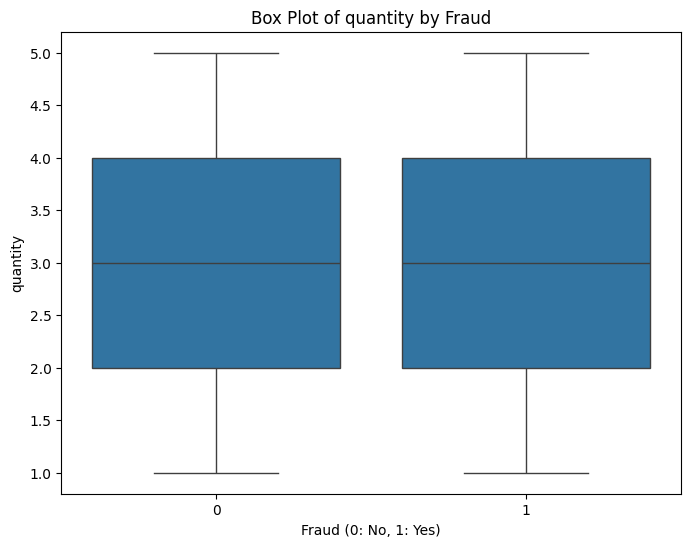

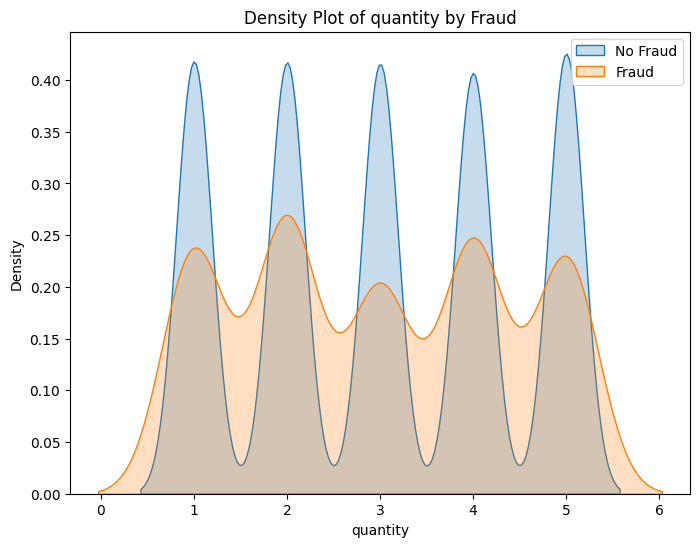


Descriptive Statistics:
                  count      mean       std  min  25%  50%  75%  max
is_fraudulent                                                      
0              22412.0  3.002320  1.419597  1.0  2.0  3.0  4.0  5.0
1               1222.0  2.968085  1.421076  1.0  2.0  3.0  4.0  5.0

-----------------------------------------------------------------------
--- Bivariate Analysis: customer_age vs. is_fraudulent ---
-----------------------------------------------------------------------


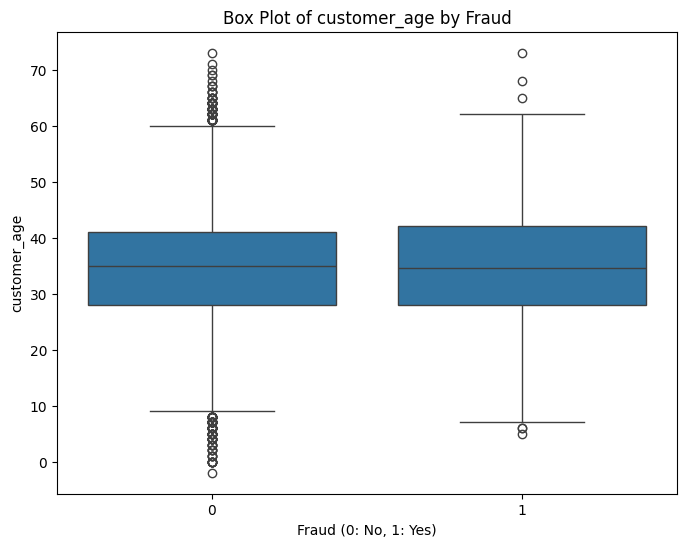

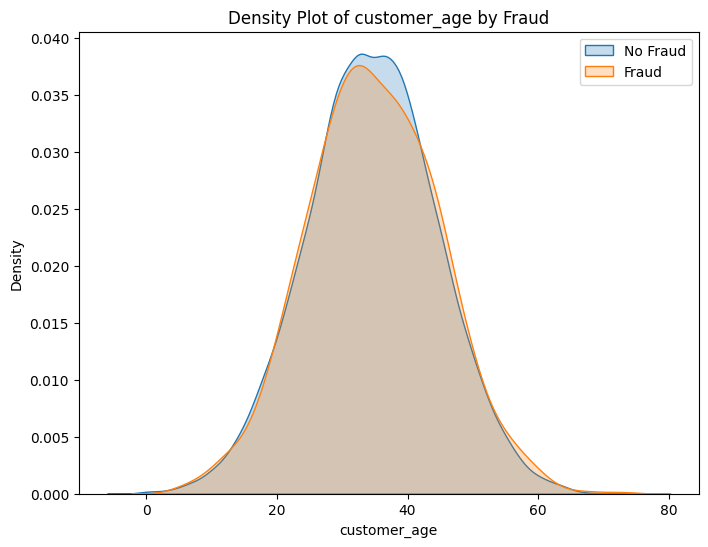


Descriptive Statistics:
                  count       mean        std  min   25%   50%   75%   max
is_fraudulent                                                            
0              22412.0  34.548947  10.004763 -2.0  28.0  35.0  41.0  73.0
1               1222.0  34.766776  10.097337  5.0  28.0  34.5  42.0  73.0

-----------------------------------------------------------------------
--- Bivariate Analysis: account_age_days vs. is_fraudulent ---
-----------------------------------------------------------------------


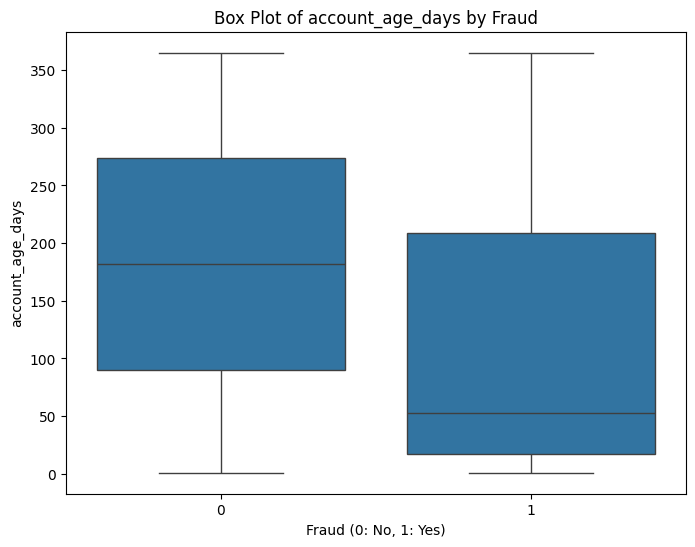

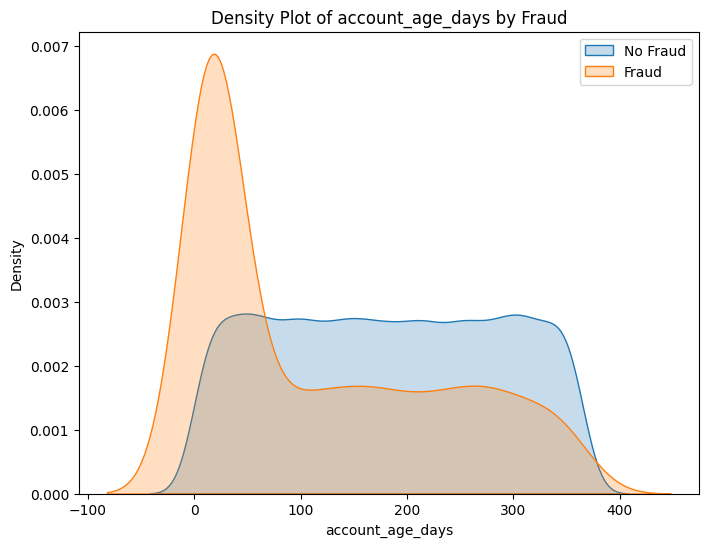


Descriptive Statistics:
                  count        mean         std  min   25%    50%     75%  \
is_fraudulent                                                              
0              22412.0  182.232911  105.821757  1.0  90.0  182.0  274.00   
1               1222.0  113.141571  114.644129  1.0  17.0   52.5  208.75   

                 max  
is_fraudulent         
0              365.0  
1              365.0  

-----------------------------------------------------------------------
--- Bivariate Analysis: transaction_hour vs. is_fraudulent ---
-----------------------------------------------------------------------


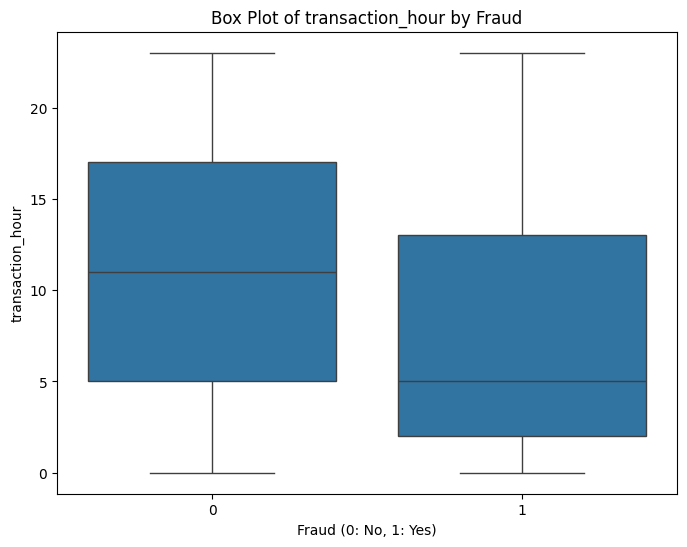

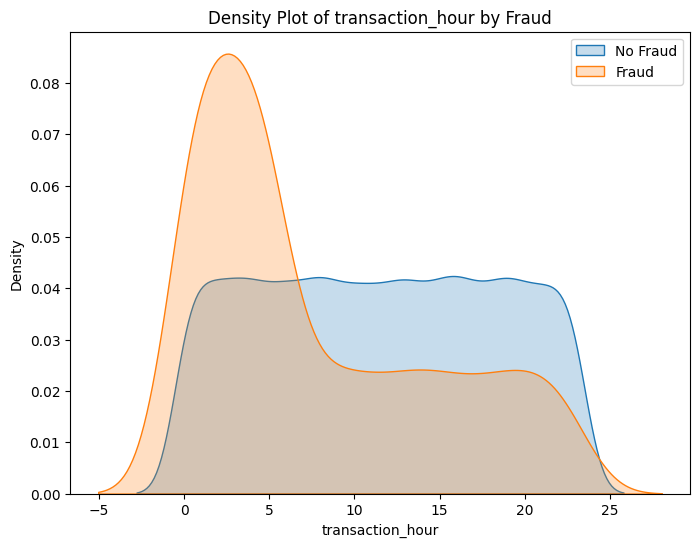


Descriptive Statistics:
                  count       mean       std  min  25%   50%   75%   max
is_fraudulent                                                          
0              22412.0  11.465242  6.925433  0.0  5.0  11.0  17.0  23.0
1               1222.0   7.612111  6.983902  0.0  2.0   5.0  13.0  23.0


In [24]:
numerical_variables = ['transaction_amount', 'quantity', 'customer_age', 'account_age_days', 'transaction_hour']
for var in numerical_variables:
    analyze_numerical_vs_fraud(df, var)


--- Bivariate Analysis: day_of_week vs. is_fraudulent ---

Contingency Table:
 is_fraudulent     0    1
day_of_week             
Friday         3181  199
Monday         3292  190
Saturday       3197  191
Sunday         3036  170
Thursday       3206  152
Tuesday        3267  175
Wednesday      3233  145

Fraud Rates per Category:
 day_of_week
Friday       0.058876
Saturday     0.056375
Monday       0.054566
Sunday       0.053026
Tuesday      0.050843
Thursday     0.045265
Wednesday    0.042925
Name: is_fraudulent, dtype: float64


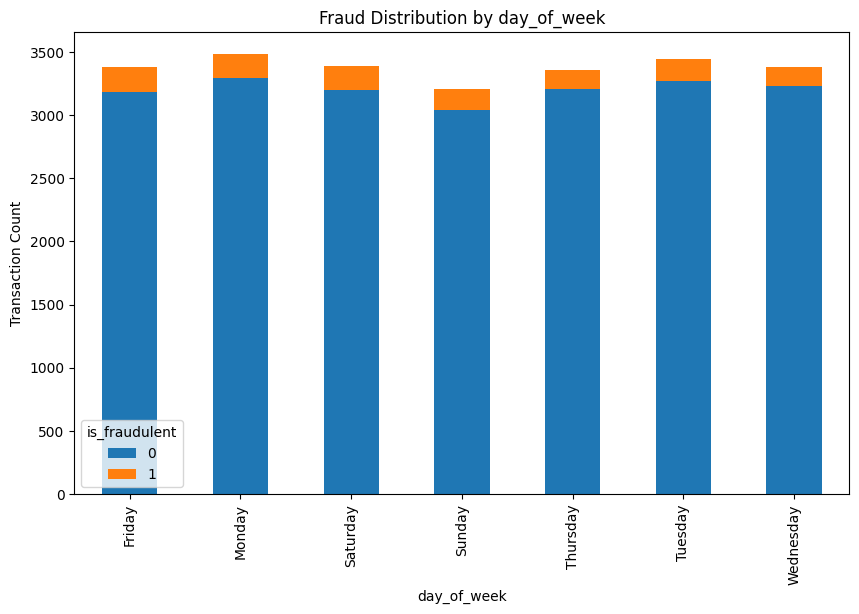


--- Bivariate Analysis: month vs. is_fraudulent ---

Contingency Table:
 is_fraudulent     0    1
month                   
April          1519   78
February       6603  341
January        7191  410
March          7099  393

Fraud Rates per Category:
 month
January     0.053940
March       0.052456
February    0.049107
April       0.048842
Name: is_fraudulent, dtype: float64


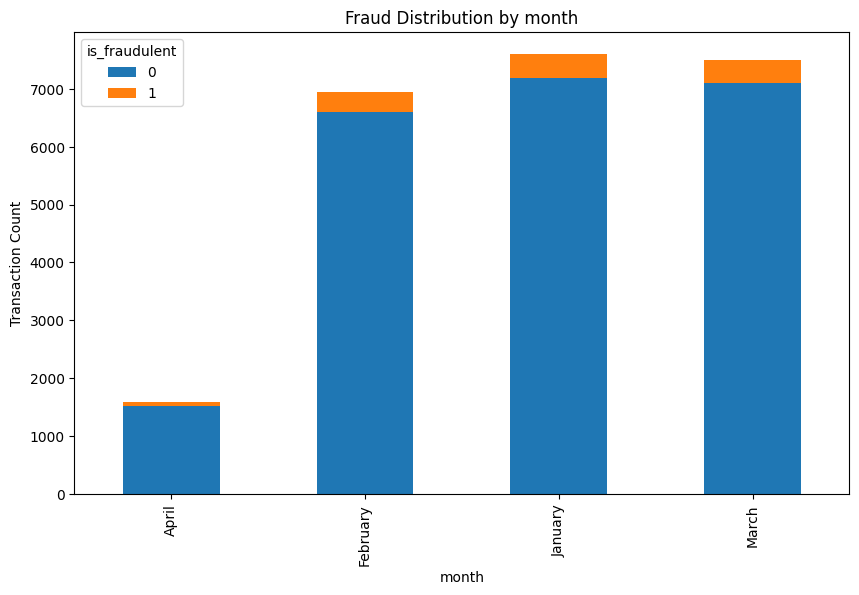

<module 'matplotlib.pyplot' from '/Users/marianamatos/ppgti/data-centric-ia/data-centric-env/lib/python3.13/site-packages/matplotlib/pyplot.py'>

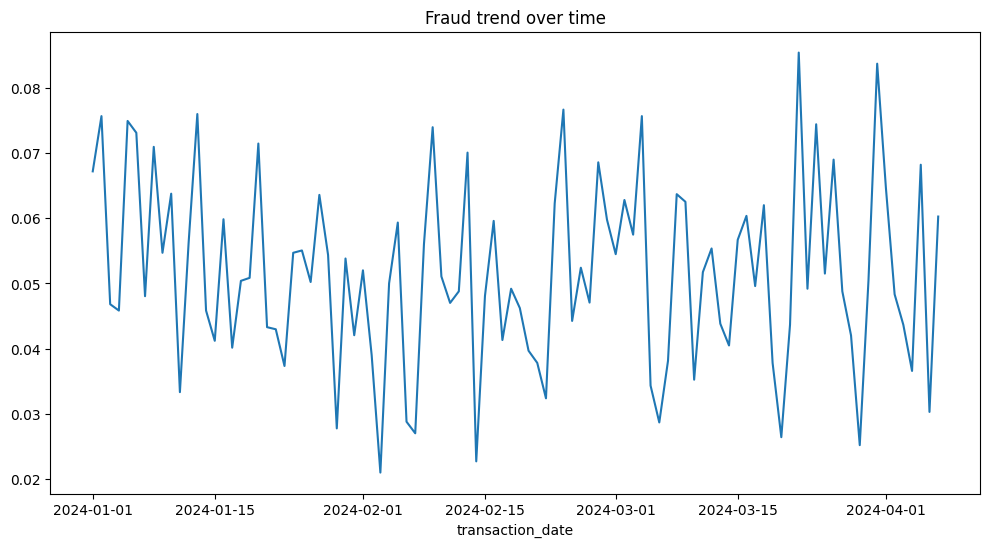

In [25]:
# 3. Temporal Variable vs. is_fraudulent

# Extract date information
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['day_of_week'] = df['transaction_date'].dt.day_name()
df['month'] = df['transaction_date'].dt.month_name()

# Fraud analysis by day of the week
analyze_categorical_vs_fraud(df, 'day_of_week')

# Fraud analysis by month
analyze_categorical_vs_fraud(df, 'month')

# Analysis of fraud trend over time (simplified example)
fraud_per_day = df.groupby(df['transaction_date'].dt.date)['is_fraudulent'].mean()
plt.figure(figsize=(12, 6))
fraud_per_day.plot()
plt.title('Fraud trend over time')
plt

In [26]:
# save dataframe containing new variables
df.to_pickle("/Users/marianamatos/ppgti/data-centric-ia/weak-supervised-fraud-detection/data/df_new_features.pkl")

In [27]:
print(df.shape[1])

24


In [28]:
df.columns

Index(['transaction_id', 'customer_id', 'transaction_amount',
       'transaction_date', 'payment_method', 'product_category', 'quantity',
       'customer_age', 'customer_location', 'device_used', 'ip_address',
       'shipping_address', 'billing_address', 'is_fraudulent',
       'account_age_days', 'transaction_hour', 'common_customer_location',
       'address_ip_relationship', 'is_ip_address_double',
       'shipping_address_repeated', 'billing_address_repeated',
       'is_addrss_ship_bill', 'day_of_week', 'month'],
      dtype='object')